In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import geopandas as gpd
from shapely.geometry import Polygon
from shapely import wkt
from shapely import wkb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.patches as mpatches

from sentinelsat import SentinelAPI
import pandas as pd
from datetime import datetime
from datetime import date
import glob
from collections import OrderedDict
import os
import csv
import random

import numpy as np

import requests
import json
import getpass

from utils.prepS2 import *
from utils.utils import reproject_wkt_4326_3460

In [3]:
# GET TRUTH 4 L1C + L2A FROM ESA CORE HUB
os.environ['COPERNICUS_USERNAME']=str(pd.read_csv('../aws_creds.csv').ESA_USERNAME.values[0])
os.environ['COPERNICUS_PWD']=str(pd.read_csv('../aws_creds.csv').ESA_PWD.values[0])
os.environ['SEDAS_USERNAME']=str(pd.read_csv('../aws_creds.csv').SEDAS_USERNAME.values[0])
os.environ['SEDAS_PWD']=str(pd.read_csv('../aws_creds.csv').SEDAS_PWD.values[0])

# Quick Sedas - ESA Comparison

AoI

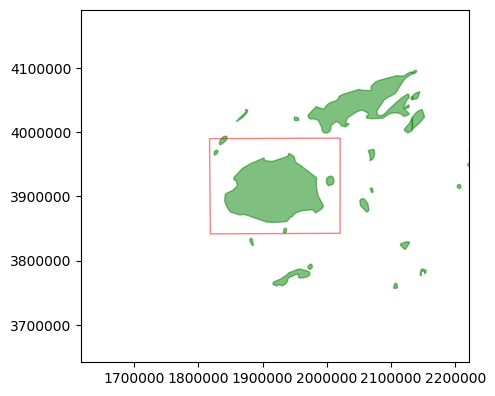

In [28]:
# wkt used for querying APIs
aoi_wkt = "POLYGON((177.03369140625 -17.084845005813943,178.9453125 -17.084845005813943,178.9453125 -18.424081459048455,177.03369140625 -18.424081459048455,177.03369140625 -17.084845005813943))"
# geopandas dataframe for plotting
aoidf = pd.DataFrame(data={'geometry': [aoi_wkt]})
aoidf['geometry'] = aoidf['geometry'].apply(wkt.loads)
# reporojected into Fiji-specific crs to overcome anti-meridian overlap. Uses custom reporject function.
aoidf['repro'] = aoidf['geometry'].apply(lambda x: reproject_wkt_4326_3460(str(x)))
aoidf['repro'] = aoidf['repro'].apply(wkt.loads)
aoigdf = gpd.GeoDataFrame(aoidf, geometry='repro', crs=('epsg:3460'))

world_borders = gpd.read_file('../Ancillary_Datasets/TM_WORLD_BORDERS-0.2/TM_WORLD_BORDERS-0.2.shp')
country_name = 'Fiji'
country = world_borders.loc[world_borders.NAME == country_name]
country['repro'] = country['geometry'].apply(lambda x: reproject_wkt_4326_3460(str(x)))
country['repro'] = country['repro'].apply(wkt.loads)
country = gpd.GeoDataFrame(country, geometry='repro', crs=('epsg:3460'))

fig, ax = plt.subplots(figsize=(5,5),dpi=100)
country.plot(facecolor='g', edgecolor='g', ax=ax, alpha=0.5);
aoigdf.plot(facecolor='', edgecolor='r', ax=ax, alpha=0.5);
ax.set_xlim(aoigdf.bounds.minx.values[0]-200000, aoigdf.bounds.maxx.values[0]+200000);
ax.set_ylim(aoigdf.bounds.miny.values[0]-200000, aoigdf.bounds.maxy.values[0]+200000);

In [26]:
# Load landsat & sentinel-2 world tiles
world_s2_granules = gpd.read_file('../Ancillary_Datasets/sentinel2_tiles_world/sentinel2_tiles_world.shp')
world_ls_granules = gpd.read_file('../Ancillary_Datasets/WRS2_descending.shp')

In [9]:
# Check column NAME exists within aoi(s) gpd
aois = gpd.read_file('../DY/DY_AoI.geojson')
aois['NAME'] = 'DY'
aois = country
aoi_wkt = aois.envelope.geometry.values[0].wkt
aoi_wkt

'POLYGON ((-180 -20.67444199999994, 180 -20.67444199999994, 180 -12.48194299999994, -180 -12.48194299999994, -180 -20.67444199999994))'

# Direct comparison querying via wkt AoI 4 Sentinel-2

Query ESA

In [29]:
esa_api = SentinelAPI(os.getenv("COPERNICUS_USERNAME"),os.getenv("COPERNICUS_PWD"))

In [45]:
res = esa_api.query(wkt_aoi,platformname='Sentinel-1',producttype='SLC')
esa_slc = esa_api.to_geodataframe(res)
res = esa_api.query(wkt_aoi,platformname='Sentinel-1',producttype='GRD')
esa_grd = esa_api.to_geodataframe(res)

Querying products: 100%|██████████| 676/676 [00:13<00:00, 30.44 products/s]


In [30]:
res = esa_api.query(aoi_wkt, platformname='Sentinel-2', producttype='S2MSI1C')
esa_l1c = esa_api.to_geodataframe(res)
res = esa_api.query(aoi_wkt, platformname='Sentinel-2',producttype='S2MSI2A')
esa_l2a = esa_api.to_geodataframe(res)

Querying products: 100%|██████████| 943/943 [00:07<00:00, 72.37 products/s] 


Query Sedas 
- naturally can't search for S2 L2A...
- (why start & end date required inputs?)

In [31]:
startDate = "2000-04-30T00:00:00Z"
endDate = "2020-05-12T23:59:59Z"
sedas = SeDASAPI(os.getenv("SEDAS_USERNAME"), os.getenv("SEDAS_PWD"))
result_optical = sedas.search_optical(aoi_wkt, startDate, endDate)

In [47]:
result_slc = sedas.search_sar(aoi_wkt, startDate, endDate, sarProductType="SLC")
result_grd = sedas.search_sar(aoi_wkt, startDate, endDate, sarProductType="GRD")

In [48]:
result_optical = pd.DataFrame(result_optical['products'])
result_grd = pd.DataFrame(result_grd['products'])
result_slc = pd.DataFrame(result_slc['products'])
result_optical.shape, result_grd.shape, result_slc.shape

((251, 24), (237, 24), (231, 24))

- Why only 256 results returned - is there a limit?
- Since no obvious reason, maybe querying by Acquisition/Product ID would find a greater no. results?

# Sedas - ESA direct product search comparison Sentinel-2

- ESA query the same
- Check Sedas per product

In [51]:
sedas_l1c = []
l1c_unavailable = []
for s2id in tqdm(esa_l1c.title.values):
    singleProduct = sedas.search_product(s2id)
    try:
        sedas_l1c.append(singleProduct[0])
    except:
        l1c_unavailable.append(s2id)
sedas_l1c = pd.DataFrame(sedas_l1c)


100%|██████████| 3389/3389 [03:24<00:00, 15.53it/s]

In [54]:
sedas_grd = []
grd_unavailable = []
for s2id in tqdm(esa_grd.title.values):
    singleProduct = sedas.search_product(s2id)
    try:
        sedas_grd.append(singleProduct[0])
    except:
        grd_unavailable.append(s2id)
sedas_grd = pd.DataFrame(sedas_grd)


100%|██████████| 676/676 [00:43<00:00, 15.57it/s]

In [55]:
sedas_slc = []
slc_unavailable = []
for s2id in tqdm(esa_slc.title.values):
    singleProduct = sedas.search_product(s2id)
    try:
        sedas_slc.append(singleProduct[0])
    except:
        slc_unavailable.append(s2id)
sedas_slc= pd.DataFrame(sedas_slc)


100%|██████████| 808/808 [00:50<00:00, 19.96it/s]

In [59]:
print(f'S2 L1C unavailable: {len(l1c_unavailable)} Available: {sedas_l1c.shape[0]}')
print(f'S2 L1C unavailable: {len(grd_unavailable)} Available: {sedas_grd.shape[0]}')
print(f'S2 L1C unavailable: {len(slc_unavailable)} Available: {sedas_slc.shape[0]}')

S2 L1C unavailable: 1224 Available: 2165
S2 L1C unavailable: 196 Available: 480
S2 L1C unavailable: 229 Available: 579


- Still a significant no. products not found - any known reason for this? Potential reasons inc. ...
    - Some tiles are missing?
    - Only single S2 platform?
    - Not immediately available / must be ordered?
    - Only finding products of recent naming convention (sedas storing full scenes rather than granules for initial collections; date tbd)?

Are all the tiles on sedas?
- Yes, seem to be...

In [60]:
sedas_tiles = set([prod.split('_')[5] for prod in sedas_prods.supplierId.values])
print(f'Tiles on Sedas:\nNo. {len(sedas_tiles)} \nNames {sedas_tiles}')
esa_tiles = set([prod.split('_')[5] for prod in esa_l1c.title.values])
print(f'Tiles on ESA:\nNo. {len(esa_tiles)} \nNames {esa_tiles}')
s2_tiles = [i[1:] for i in esa_tiles]

Tiles on Sedas:
No. 12 
Names {'T60KXG', 'T60KYG', 'T60KVF', 'T60KWE', 'T60KXF', 'T60KWG', 'T60KYF', 'T60KVE', 'T60KWF', 'T60KYE', 'T60KXE', 'T60KVG'}
Tiles on ESA:
No. 12 
Names {'T60KXG', 'T60KYG', 'T60KVF', 'T60KWE', 'T60KXF', 'T60KWG', 'T60KYF', 'T60KVE', 'T60KWF', 'T60KYE', 'T60KXE', 'T60KVG'}


In [39]:
df = esa_l1c
print(df.shape)
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
df = df.dropna(subset=['tileid'])
print(df.shape)

(3389, 34)
(3185, 35)


**Temporal availability** (single platform + naming convention?)

Throw in Google for fun...

In [40]:
gc = pd.read_csv('../Ancillary_Datasets/L2_index.csv.gz')
gc_l2a = gc[ gc.MGRS_TILE.isin(s2_tiles) ]
gc= None

In [41]:
gc = pd.read_csv('../Ancillary_Datasets/gc_index.csv.gz')
gc_l1c = gc[ gc.MGRS_TILE.isin(s2_tiles) ]
gc = None

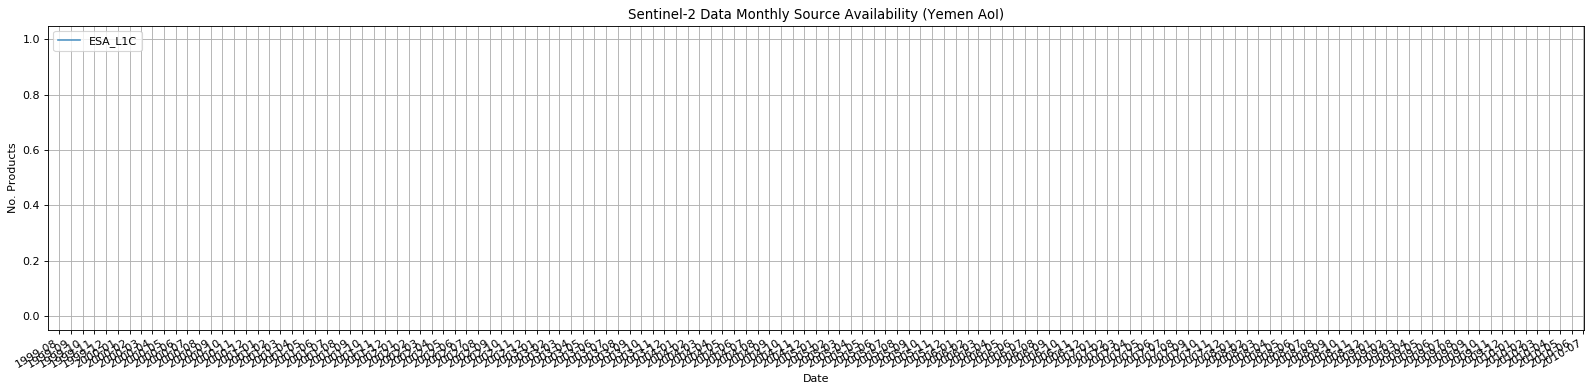

In [104]:
# Create monthly data availability plot from each data source.
fig, ax = plt.subplots(figsize=(20,5),dpi=80)
fig.autofmt_xdate()

# df = esa_l1c
# # df = df.dropna(subset=['TOTAL_SIZE'])
# df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
# df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
# df.index.to_timestamp(freq ='M').values
# ax.plot(df.index.to_timestamp(freq ='M').values, df.values, alpha = 0.75);

# df = esa_l2a
# # df = df.dropna(subset=['TOTAL_SIZE'])
# df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
# df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
# df.index.to_timestamp(freq ='M').values
# ax.plot(df.index.to_timestamp(freq ='M').values, df.values, '--', alpha = 0.75);

# df = res
# # df = df.dropna(subset=['TOTAL_SIZE'])
# df['Acquisition Date'] = pd.to_datetime(df['start'], format='%Y-%m-%d', utc=True)
# df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
# df.index.to_timestamp(freq ='M').values
# ax.plot(df.index.to_timestamp(freq ='M').values, df.values, alpha = 0.75);

# df = sedas_prods
# # df = df.dropna(subset=['TOTAL_SIZE'])
# df['Acquisition Date'] = pd.to_datetime(df['start'], format='%Y-%m-%d', utc=True)
# df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
# df.index.to_timestamp(freq ='M').values
# ax.plot(df.index.to_timestamp(freq ='M').values, df.values, alpha = 0.75);

df = gc_l2a
# df = df.dropna(subset=['TOTAL_SIZE'])
df['Acquisition Date'] = pd.to_datetime(df['SENSING_TIME'], format='%Y-%m-%d', utc=True)
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values, alpha = 0.75);

ax.set_ylabel("No. Products");
ax.set_xlabel("Date");
#ax.set_ylim(0,40)
ax.legend(['ESA_L1C','ESA_L2A','Sedas_L1C(AoI)','Sedas_L1C(PerProd)','Gcloud_L1C','Gcloud_L2A'], loc='upper left');
#ax.legend.loc('upper left')
ax.set_title('Sentinel-2 Data Monthly Source Availability (Yemen AoI)');
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m") ) 
ax.grid();
fig.tight_layout();

In [42]:
print(gc_l1c.shape)
df = gc_l1c
df = df.dropna(subset=['TOTAL_SIZE'])
df.shape

(3476, 14)


(3416, 14)

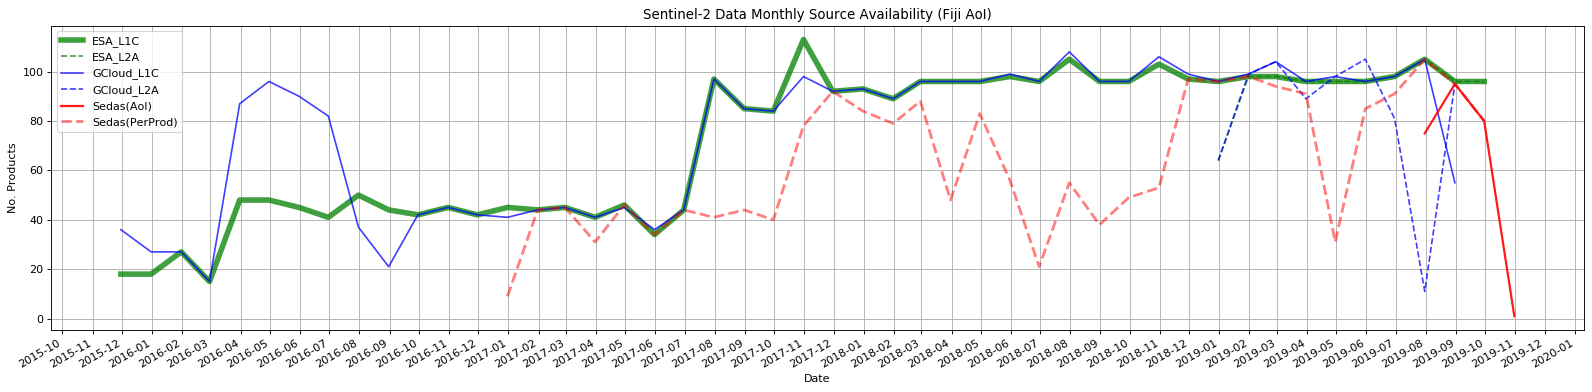

In [61]:
# Create monthly data availability plot from each data source.
fig, ax = plt.subplots(figsize=(20,5),dpi=80)
fig.autofmt_xdate()

df = esa_l1c
# Convert dates into datetime objects
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%dT%H:%M:%S', utc=True)
# df = df.dropna(subset=['TOTAL_SIZE'])
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values, color='green', linewidth=5, alpha = 0.75);

df = esa_l2a
# Convert dates into datetime objects
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%dT%H:%M:%S', utc=True)
# df = df.dropna(subset=['TOTAL_SIZE'])
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values, '--', color='green', alpha = 0.75);

df = gc_l1c
# Convert dates into datetime objects
df['Acquisition Date'] = pd.to_datetime(df['SENSING_TIME'], format='%Y-%m-%dT%H:%M:%S', utc=True)
df = df.dropna(subset=['TOTAL_SIZE'])
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values, color='blue', alpha = 0.75);

df = gc_l2a
# Convert dates into datetime objects
df['Acquisition Date'] = pd.to_datetime(df['SENSING_TIME'], format='%Y-%m-%dT%H:%M:%S', utc=True)
df = df.dropna(subset=['TOTAL_SIZE'])
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values, '--', color='blue', alpha = 0.75);

df = result_optical
# Convert dates into datetime objects
df['Acquisition Date'] = pd.to_datetime(df['start'], format='%Y-%m-%dT%H:%M:%S', utc=True)
# df = df.dropna(subset=['TOTAL_SIZE'])
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values, color='red', alpha = 0.9, linewidth=2);

df = sedas_l1c
# Convert dates into datetime objects
df['Acquisition Date'] = pd.to_datetime(df['start'], format='%Y-%m-%dT%H:%M:%S', utc=True)
# df = df.dropna(subset=['TOTAL_SIZE'])
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values, '--', color='red', linewidth=2.5, alpha = 0.5);

ax.set_ylabel("No. Products");
ax.set_xlabel("Date");
#ax.set_ylim(0,40)
ax.legend(['ESA_L1C','ESA_L2A','GCloud_L1C','GCloud_L2A','Sedas(AoI)','Sedas(PerProd)'], loc='upper left');
#ax.legend.loc('upper left')
ax.set_title('Sentinel-2 Data Monthly Source Availability (Fiji AoI)');
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m") ) 
ax.grid();
fig.tight_layout();

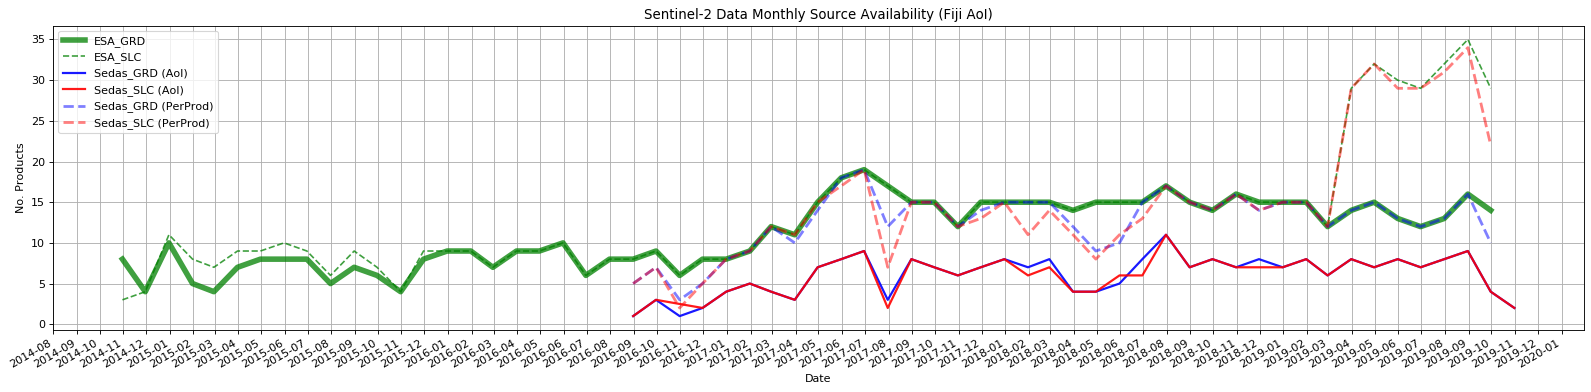

In [68]:
# Create monthly data availability plot from each data source.
fig, ax = plt.subplots(figsize=(20,5),dpi=80)
fig.autofmt_xdate()

df = esa_grd
# Convert dates into datetime objects
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%dT%H:%M:%S', utc=True)
# df = df.dropna(subset=['TOTAL_SIZE'])
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values, color='green', linewidth=5, alpha = 0.75);

df = esa_slc
# Convert dates into datetime objects
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%dT%H:%M:%S', utc=True)
# df = df.dropna(subset=['TOTAL_SIZE'])
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values, '--', color='green', alpha = 0.75);

df = result_grd
# Convert dates into datetime objects
df['Acquisition Date'] = pd.to_datetime(df['start'], format='%Y-%m-%dT%H:%M:%S', utc=True)
# df = df.dropna(subset=['TOTAL_SIZE'])
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values, color='b', alpha = 0.9, linewidth=2);

df = result_slc
# Convert dates into datetime objects
df['Acquisition Date'] = pd.to_datetime(df['start'], format='%Y-%m-%dT%H:%M:%S', utc=True)
# df = df.dropna(subset=['TOTAL_SIZE'])
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values, color='red', alpha = 0.9, linewidth=2);

df = sedas_grd
# Convert dates into datetime objects
df['Acquisition Date'] = pd.to_datetime(df['start'], format='%Y-%m-%dT%H:%M:%S', utc=True)
# df = df.dropna(subset=['TOTAL_SIZE'])
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values, '--', color='b', linewidth=2.5, alpha = 0.5);

df = sedas_slc
# Convert dates into datetime objects
df['Acquisition Date'] = pd.to_datetime(df['start'], format='%Y-%m-%dT%H:%M:%S', utc=True)
# df = df.dropna(subset=['TOTAL_SIZE'])
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values, '--', color='red', linewidth=2.5, alpha = 0.5);

ax.set_ylabel("No. Products");
ax.set_xlabel("Date");
#ax.set_ylim(0,40)
ax.legend(['ESA_GRD','ESA_SLC','Sedas_GRD (AoI)','Sedas_SLC (AoI)','Sedas_GRD (PerProd)','Sedas_SLC (PerProd)'], loc='upper left');
#ax.legend.loc('upper left')
ax.set_title('Sentinel-2 Data Monthly Source Availability (Fiji AoI)');
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m") ) 
ax.grid();
fig.tight_layout();

In [147]:
sedas_prods.head(2)

,productId,supplierId,type,satelliteName,instrumentName,modeName,sensorType,sensorResolution,coordinatesWKT,start,...,aoiCoveragePercent,usefulAreaPercent,cloudCoveragePercent,productType,latency,ql,thumbnail,vendorSpecific,downloadUrl,Acquisition Date
0,6f6d6d83911a5738291f7f79936cb9d7,S2B_MSIL1C_20190925T071629_N0208_R006_T38PNV_2...,ARCHIVE,Sentinel-2B,MSI,Nominal,Optical,10.0,"POLYGON((44.999815 13.568451,46.014647 13.5663...",2019-09-25T07:16:29Z,...,0.0,0.0,0.0,L1C,Standard,https://geobrowser.satapps.org/archiveql/aeweb...,https://sedasdm.satapps.org/qls/qlmgr.php?scen...,"{'property': 'vendorSpecific', 'Filehash': '95...",https://sedasdm.satapps.org/datamgr/datamgr.ph...,2019-09-25 07:16:29+00:00
1,6c0244d0e9caab1d64a5047eb4131215,S2B_MSIL1C_20190925T071629_N0208_R006_T38PNB_2...,ARCHIVE,Sentinel-2B,MSI,Nominal,Optical,10.0,"POLYGON((44.999814 15.37714,46.022895 15.37479...",2019-09-25T07:16:29Z,...,0.0,0.0,42.0,L1C,Standard,https://geobrowser.satapps.org/archiveql/aeweb...,https://sedasdm.satapps.org/qls/qlmgr.php?scen...,"{'property': 'vendorSpecific', 'Filehash': '0e...",https://sedasdm.satapps.org/datamgr/datamgr.ph...,2019-09-25 07:16:29+00:00


In [149]:
list(sedas_prods.downloadUrl.values)

['https://sedasdm.satapps.org/datamgr/datamgr.php?p=Default&sceneid=S2B_MSIL1C_20190925T071629_N0208_R006_T38PNV_20190925T110036.zip',
 'https://sedasdm.satapps.org/datamgr/datamgr.php?p=Default&sceneid=S2B_MSIL1C_20190925T071629_N0208_R006_T38PNB_20190925T110036.zip',
 'https://sedasdm.satapps.org/datamgr/datamgr.php?p=Default&sceneid=S2B_MSIL1C_20190925T071629_N0208_R006_T38PMC_20190925T110036.zip',
 'https://sedasdm.satapps.org/datamgr/datamgr.php?p=Default&sceneid=S2B_MSIL1C_20190925T071629_N0208_R006_T38PMB_20190925T110036.zip',
 'https://sedasdm.satapps.org/datamgr/datamgr.php?p=Default&sceneid=S2B_MSIL1C_20190925T071629_N0208_R006_T38PMA_20190925T110036.zip',
 'https://sedasdm.satapps.org/datamgr/datamgr.php?p=Default&sceneid=S2B_MSIL1C_20190925T071629_N0208_R006_T38PLV_20190925T110036.zip',
 'https://sedasdm.satapps.org/datamgr/datamgr.php?p=Default&sceneid=S2B_MSIL1C_20190925T071629_N0208_R006_T38PMV_20190925T110036.zip',
 'https://sedasdm.satapps.org/datamgr/datamgr.php?p=Def

In [152]:
df = sedas_prods.dropna(subset=['downloadUrl'])
print(df.shape, sedas_prods.shape)

(93, 24) (2848, 24)


In [151]:
sedas_prods.columns

Index(['productId', 'supplierId', 'type', 'satelliteName', 'instrumentName',
       'modeName', 'sensorType', 'sensorResolution', 'coordinatesWKT', 'start',
       'stop', 'orbit', 'orbitDirection', 'area', 'aoiCoveragePercent',
       'usefulAreaPercent', 'cloudCoveragePercent', 'productType', 'latency',
       'ql', 'thumbnail', 'vendorSpecific', 'downloadUrl', 'Acquisition Date'],
      dtype='object')

In [156]:
print( 'S2B_MSIL1C_20180811T071609_N0206_R006_T38PQA_20180811T112331' in unavailable)

False
